<a href="https://colab.research.google.com/github/Chiosas/Cat_in_the_Dat_2/blob/master/Categorical_Features_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'project'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

In [0]:
if IN_COLAB and FIRST_RUN:
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    # pass

### ***Kaggle Setup***

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

In [0]:
competition_name = 'cat-in-the-dat-ii'

if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.competition_download_files(competition=competition_name, path=DATA_DIR)

In [0]:
import zipfile

zip_name = f'{competition_name}.zip'
if IN_COLAB and FIRST_RUN:
    with zipfile.ZipFile(DATA_DIR/zip_name, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

### ***Importing Dependencies***

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__

'2.2.0'

In [13]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classic ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Helper libraries
import pickle
import joblib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### ***Content***

![Categories](https://2.bp.blogspot.com/-gNMIOHboLMo/T1Dlp5pi3uI/AAAAAAAAAVc/80O8Ao9rrfQ/s1600/Categories+Excel.jpg)

In this [competition](https://www.kaggle.com/c/cat-in-the-dat-ii), we will be predicting the probability [0, 1] of a binary target column.

The data contains:
- binary features (bin_*),
- nominal features (nom_*),
- ordinal features (ord_*),
- potentially cyclical - day (of the week) and month features.

The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters.

Since the purpose of this competition is to explore various encoding strategies, the data for this challenge has missing values and feature interactions.

### ***Files***
- *train.csv* - the training set,
- *test.csv* - the test set; you must make predictions against this data,
- *sample_submission.csv* - a sample submission file in the correct format.

### ***Evaluation***
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [0]:
# Reading the data from the file
raw_data = pd.read_csv(DATA_DIR/'train.csv', low_memory=False)

### ***Data Exploration***

In [17]:
raw_data.sample(10).T

,456472,442792,58524,215489,179896,419136,547578,351015,203841,196749
id,456472,442792,58524,215489,179896,419136,547578,351015,203841,196749
bin_0,1,0,0,0,0,0,0,0,0,0
bin_1,0,0,0,0,0,1,0,0,0,0
bin_2,0,0,0,0,0,0,0,0,0,0
bin_3,F,T,F,T,F,F,F,T,T,T
bin_4,N,N,N,N,N,N,Y,N,Y,Y
nom_0,Red,Green,Blue,Blue,Red,Blue,Red,Blue,Red,Green
nom_1,Trapezoid,Triangle,Circle,Trapezoid,Triangle,Polygon,Triangle,Polygon,Circle,Trapezoid
nom_2,Lion,Lion,Axolotl,Cat,Axolotl,Dog,NaN,Hamster,Hamster,Hamster
nom_3,Costa Rica,Canada,Costa Rica,Russia,India,India,Russia,Costa Rica,Russia,India


In [18]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      600000 non-null  int64  
 1   bin_0   582106 non-null  float64
 2   bin_1   581997 non-null  float64
 3   bin_2   582070 non-null  float64
 4   bin_3   581986 non-null  object 
 5   bin_4   581953 non-null  object 
 6   nom_0   581748 non-null  object 
 7   nom_1   581844 non-null  object 
 8   nom_2   581965 non-null  object 
 9   nom_3   581879 non-null  object 
 10  nom_4   581965 non-null  object 
 11  nom_5   582222 non-null  object 
 12  nom_6   581869 non-null  object 
 13  nom_7   581997 non-null  object 
 14  nom_8   582245 non-null  object 
 15  nom_9   581927 non-null  object 
 16  ord_0   581712 non-null  float64
 17  ord_1   581959 non-null  object 
 18  ord_2   581925 non-null  object 
 19  ord_3   582084 non-null  object 
 20  ord_4   582070 non-null  object 
 21  ord_5   58

In [19]:
raw_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,600000,NaN,NaN,NaN,300000,173205,0,150000,300000,449999,599999
bin_0,582106,NaN,NaN,NaN,0.0923011,0.289451,0,0,0,0,1
bin_1,581997,NaN,NaN,NaN,0.185532,0.388729,0,0,0,0,1
bin_2,582070,NaN,NaN,NaN,0.278704,0.448362,0,0,0,1,1
bin_3,581986,2,F,366212,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bin_4,581953,2,N,312344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nom_0,581748,3,Red,323286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nom_1,581844,6,Triangle,164190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nom_2,581965,6,Hamster,164897,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nom_3,581879,6,India,164869,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Unique Values
unique_vals = raw_data.nunique()

# Null Values
null_vals = raw_data.isnull().sum()

df_vals = pd.concat([unique_vals, null_vals], axis=1)
df_vals.columns = ['Number of unique', 'Number of NaN values']
df_vals

,Number of unique,Number of NaN values
id,600000,0
bin_0,2,17894
bin_1,2,18003
bin_2,2,17930
bin_3,2,18014
bin_4,2,18047
nom_0,3,18252
nom_1,6,18156
nom_2,6,18035
nom_3,6,18121


In [21]:
raw_data.shape

(600000, 25)

In [22]:
raw_data.dropna().shape

(298042, 25)

In [23]:
# Counting missing values per record
raw_data.isna().sum(axis=1).value_counts()

0    298042
1    211383
2     72111
3     15664
4      2487
5       294
6        18
7         1
dtype: int64

In [24]:
bin_cols = list(raw_data.loc[:, 'bin_0':'bin_4'].columns)
nom_low_cols = list(raw_data.loc[:, 'nom_0':'nom_4'].columns)
nom_high_cols = list(raw_data.loc[:, 'nom_5':'nom_9'].columns)
ord_low_cols = list(raw_data.loc[:, 'ord_0':'ord_2'].columns)
ord_high_cols = list(raw_data.loc[:, 'ord_3':'ord_5'].columns)
cycle_cols = ['day', 'month']

feature_cols = [bin_cols, nom_low_cols, nom_high_cols, ord_low_cols, ord_high_cols, cycle_cols]

record_col = 'id'
target_col = 'target'

raw_data[target_col].value_counts()

0    487677
1    112323
Name: target, dtype: int64

In [0]:
def bar_plot(data_df, feature, target):
    # counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()

    # setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor='black', orient='h')

    # adding chart title
    plt.title('Number of Records per Class', size=14)

    # adding custom labels for axes
    plt.ylabel('Class')
    plt.xlabel('# of Records')

    # adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature] / 1000:.1f} k', color='black', ha="center", size=11)

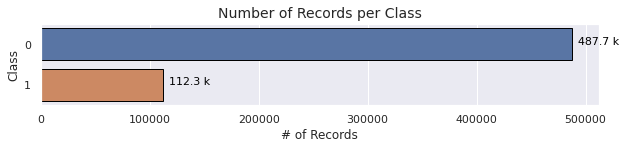

In [26]:
bar_plot(raw_data, record_col, target_col)

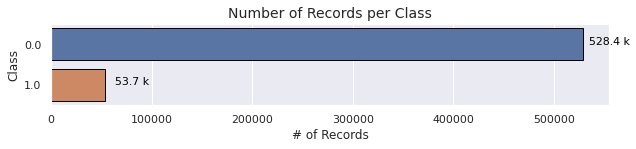

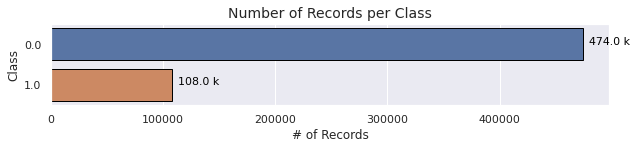

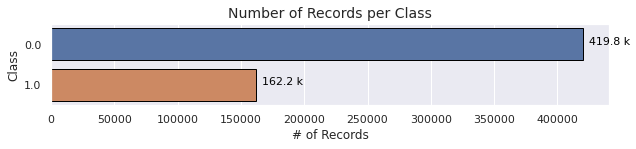

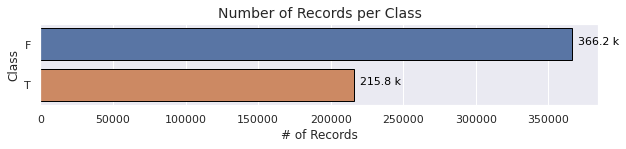

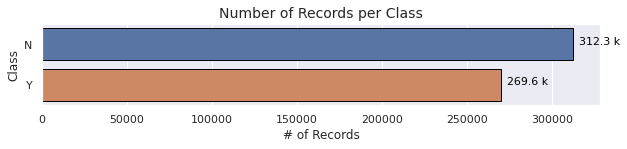

In [27]:
for col in bin_cols:
    bar_plot(raw_data, record_col, col)

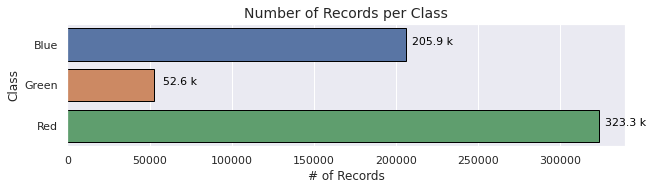

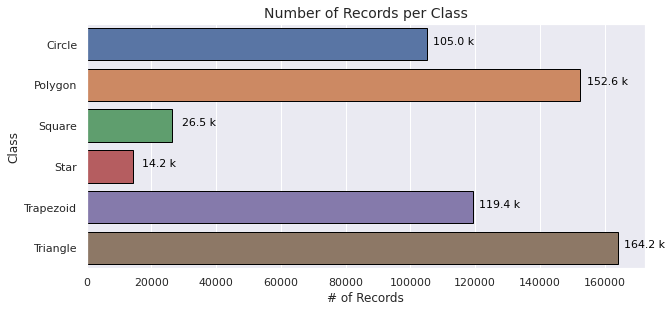

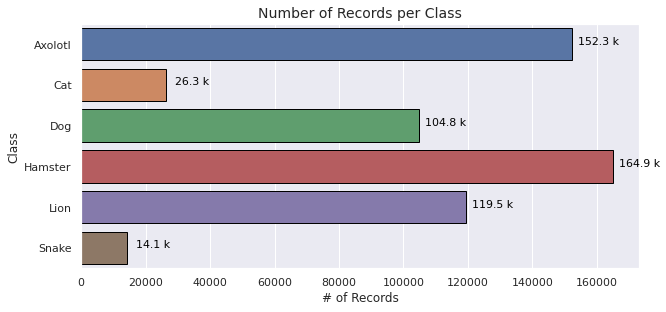

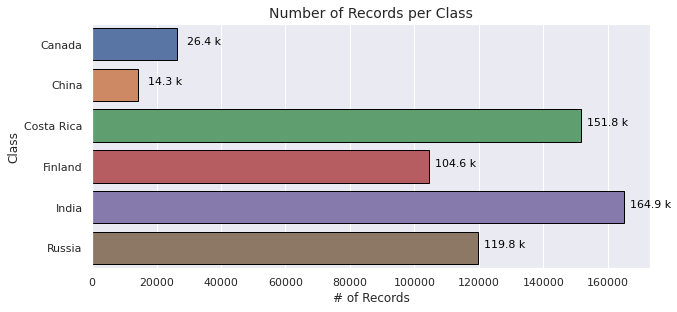

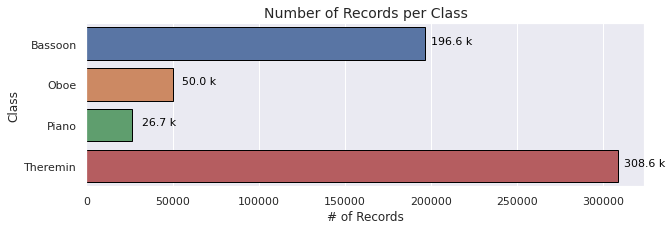

In [28]:
for col in nom_low_cols:
    bar_plot(raw_data, record_col, col)

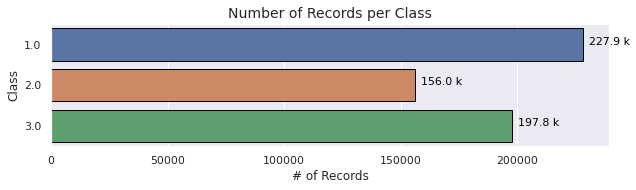

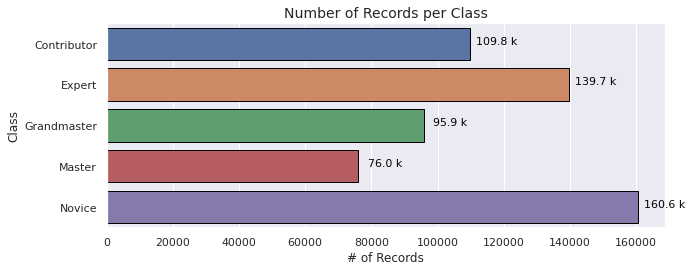

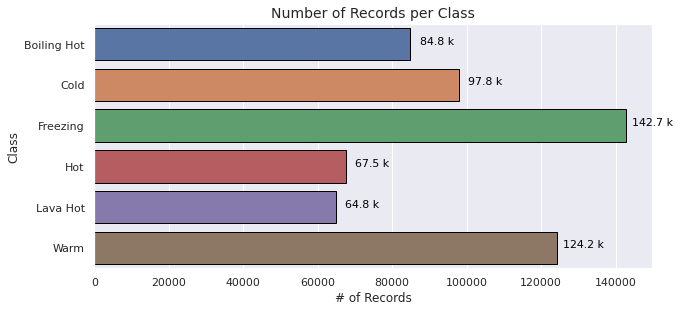

In [29]:
for col in ord_low_cols:
    bar_plot(raw_data, record_col, col)

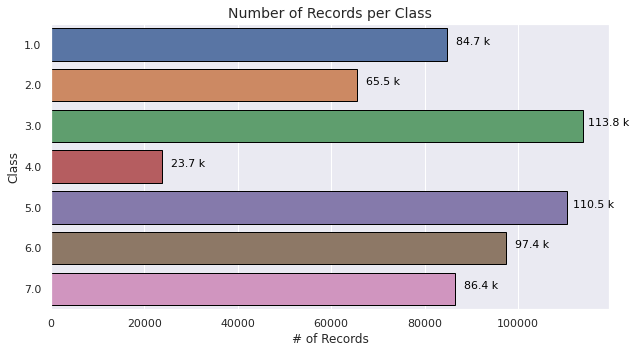

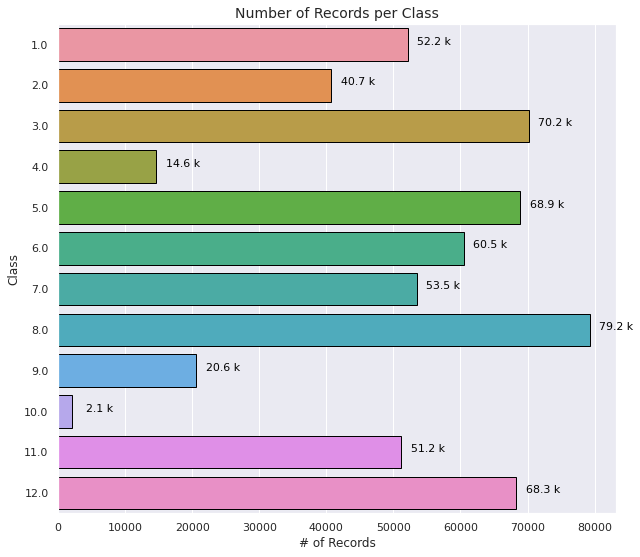

In [30]:
for col in cycle_cols:
    bar_plot(raw_data, record_col, col)

## ***Data Preparation***

### ***Data Split***

In [0]:
def data_split(data=None, stratify_col=None, size=0.2, save_data=False, load_data=False):
    # Setting variables
    train_data, val_data, test_data = None, None, None
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.pkl', 'val_data.pkl', 'test_data.pkl']

    if type(data) == type(pd.DataFrame()):
        # Data split part
        train_data, testval_data = train_test_split(data, test_size=size, random_state=15, stratify=data[stratify_col])
        val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[stratify_col])

        # Assigning file data contents
        file_contents = [train_data, val_data, test_data]

        # Reseting indices on data
        for contents in file_contents:
            contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_pickle(DATA_DIR/name)
    
    # Loading data from csv files
    if load_data:
        for pos, name in enumerate(file_names):
            file_contents[pos] = pd.read_pickle(DATA_DIR/name)

        train_data, val_data, test_data = file_contents

    return train_data, val_data, test_data

In [0]:
# Spliting data into train, validation and test sets
train_data, val_data, test_data = data_split(raw_data, target_col, size=0.2, save_data=True, load_data=True)

In [33]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(480000, 25), (60000, 25), (60000, 25)]

In [34]:
train_data.sample(5).T

,29258,348279,368298,383699,242989
id,49141,579450,20908,406281,369149
bin_0,0,0,0,1,0
bin_1,0,0,0,0,0
bin_2,0,0,1,1,1
bin_3,F,F,F,T,F
bin_4,Y,N,NaN,NaN,N
nom_0,Red,Blue,Red,Green,Red
nom_1,Triangle,Circle,Triangle,Circle,Trapezoid
nom_2,Axolotl,Hamster,Axolotl,Lion,Lion
nom_3,Canada,Russia,Finland,Russia,Costa Rica


In [0]:
class_weights = compute_class_weight('balanced', np.unique(train_data[target_col]), train_data[target_col])

### ***Data Preprocessing***

In [0]:
def binary_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'binary_encoder.pkl'

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna('NA')
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = encoder.get_feature_names(features)
        enc_cols = [f'{old}_{new}' for old, new in zip(enc_cols, ['enc'] * len(enc_cols))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]).toarray(), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def nom_low_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'nom_low_encoder.pkl'

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna('NA')
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = encoder.get_feature_names(features)
        enc_cols = [f'{old}_{new}' for old, new in zip(enc_cols, ['enc'] * len(enc_cols))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]).toarray(), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def nom_high_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'nom_high_encoder.pkl'

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna(0)
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OrdinalEncoder()
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = [f'{old}_{new}' for old, new in zip(features, ['enc'] * len(features))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def ord_low_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'ord_low_encoder.pkl'
    levels = ['NA', '1.0', '2.0', '3.0']
    expertise = ['NA', 'Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
    temperature = ['NA', 'Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna('NA')
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OrdinalEncoder(categories=[levels, expertise, temperature])
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = [f'{old}_{new}' for old, new in zip(features, ['enc'] * len(features))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def ord_high_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'ord_high_encoder.pkl'

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna(0)
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OrdinalEncoder()
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = [f'{old}_{new}' for old, new in zip(features, ['enc'] * len(features))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def cycle_encode(data, features, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'cycle_encoder.pkl'
    days = ['NA', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']
    months = ['NA', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']

    # Filling NaN values and changing feature data type
    data[features] = data[features].fillna('NA')
    data[features] = data[features].astype('str')

    # Fitting feature encoder & saving to pickle file
    if fit_data:
        encoder = OrdinalEncoder(categories=[days, months])
        encoder.fit(data[features])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file & transforming features
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        enc_cols = [f'{old}_{new}' for old, new in zip(features, ['enc'] * len(features))]
        data[enc_cols] = pd.DataFrame(encoder.transform(data[features]), columns=enc_cols, dtype='int')

    return data, encoder

In [0]:
def preprocess_pipeline (data, features, fit_data=False, transform_data=False):
    data = data.copy()
    bin_cols, nom_low_cols, nom_high_cols, ord_low_cols, ord_high_cols, cycle_cols = features

    data, bin_encoder = binary_encode(data, bin_cols, fit_data, transform_data)
    data, nom_low_encoder = nom_low_encode(data, nom_low_cols, fit_data, transform_data)
    data, nom_high_encoder = nom_high_encode(data, nom_high_cols, fit_data, transform_data)
    data, ord_low_encoder = ord_low_encode(data, ord_low_cols, fit_data, transform_data)
    data, ord_high_encoder = ord_high_encode(data, ord_high_cols, fit_data, transform_data)
    data, cycle_encoder = cycle_encode(data, cycle_cols, fit_data, transform_data)

    encoders = [bin_encoder, nom_low_encoder, nom_high_encoder, ord_low_encoder, ord_high_encoder, cycle_encoder]

    return data, encoders

In [0]:
train_data, encoders = preprocess_pipeline(train_data, feature_cols, fit_data=True, transform_data=True)

In [44]:
bin_encoder, nom_low_encoder, nom_high_encoder, ord_low_encoder, ord_high_encoder, cycle_encoder = encoders
ord_low_encoder.categories_

[array(['NA', '1.0', '2.0', '3.0'], dtype=object),
 array(['NA', 'Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'],
       dtype=object),
 array(['NA', 'Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot'],
       dtype=object)]

In [45]:
train_data[list(train_data.filter(regex='ord_[0-2]'))].sample(10).T

,222526,147994,357450,239716,229967,311118,214009,154087,56921,349523
ord_0,3.0,1.0,3.0,1.0,2.0,1.0,3.0,2.0,3.0,1.0
ord_1,Expert,Novice,Novice,Grandmaster,Contributor,Novice,Master,Novice,Grandmaster,Expert
ord_2,NA,Freezing,Cold,Lava Hot,Lava Hot,Freezing,Hot,Hot,Boiling Hot,NA
ord_0_enc,3,1,3,1,2,1,3,2,3,1
ord_1_enc,3,1,1,5,2,1,4,1,5,3
ord_2_enc,0,1,2,6,6,1,4,4,5,0


In [46]:
train_data.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target', 'bin_0_0.0_enc', 'bin_0_1.0_enc', 'bin_0_NA_enc',
       'bin_1_0.0_enc', 'bin_1_1.0_enc', 'bin_1_NA_enc', 'bin_2_0.0_enc',
       'bin_2_1.0_enc', 'bin_2_NA_enc', 'bin_3_F_enc', 'bin_3_NA_enc',
       'bin_3_T_enc', 'bin_4_N_enc', 'bin_4_NA_enc', 'bin_4_Y_enc',
       'nom_0_Blue_enc', 'nom_0_Green_enc', 'nom_0_NA_enc', 'nom_0_Red_enc',
       'nom_1_Circle_enc', 'nom_1_NA_enc', 'nom_1_Polygon_enc',
       'nom_1_Square_enc', 'nom_1_Star_enc', 'nom_1_Trapezoid_enc',
       'nom_1_Triangle_enc', 'nom_2_Axolotl_enc', 'nom_2_Cat_enc',
       'nom_2_Dog_enc', 'nom_2_Hamster_enc', 'nom_2_Lion_enc', 'nom_2_NA_enc',
       'nom_2_Snake_enc', 'nom_3_Canada_enc', 'nom_3_China_enc',
       'nom_3_Costa Rica_enc', 'nom_3_Finland_enc', 'nom_3_India_enc

In [0]:
val_data, _ = preprocess_pipeline(val_data, feature_cols, transform_data=True)

### ***Feature Engineering***

### ***Data Upsampling & Downsampling***

In [0]:
train_major = train_data[train_data[target_col]==0]
train_minor = train_data[train_data[target_col]==1]

In [0]:
train_minor_up = resample(
    train_minor,
    replace=True,
    n_samples=len(train_minor)*3,
    random_state=10
)

In [0]:
train_data = pd.concat([train_major, train_minor_up])

In [51]:
train_data.shape

(659716, 83)

### ***Data Cleaning***

In [0]:
train_labels = train_data[target_col]
train_data = train_data[list(train_data.filter(regex='enc'))]

val_labels = val_data[target_col]
val_data = val_data[list(val_data.filter(regex='enc'))]

## ***Classic ML Models***

### ***Helper Functions***

In [0]:
def model_predictions(model, data, labels):
    # Predicting labels
    preds = model.predict(data) > 0.5
    probs = model.predict_proba(data)[:, 1]

    # Printing metrics
    model_prec = precision_score(labels, preds, average='weighted')
    print(f'Precision score: {model_prec:.2%}')

    model_accu = accuracy_score(labels, preds)
    print(f'Accuracy score: {model_accu:.2%}')

    model_f1 = f1_score(labels, preds, average='macro')
    print(f'F1 score: {model_f1:.2%}')

    model_roc_auc = roc_auc_score(labels, preds, average='macro')
    print(f'ROC AUC score: {model_roc_auc:.2%}')

    return preds, probs

In [0]:
def confusion_matrix_chart(matrix, name):
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(f'{name} Confusion Matrix')

In [0]:
def roc_auc_chart(fpr, tpr, name):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

### ***Logistic Regression***

In [0]:
model_name = 'Logistic Regression'
model_file = 'LR.pkl'
model = LogisticRegression(class_weight=class_weights, solver='lbfgs', max_iter=10000, verbose=1, n_jobs=-1)

In [66]:
model.fit(train_data, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 64.5min finished


LogisticRegression(C=1.0, class_weight=array([0.61516063, 2.67088072]),
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='auto', n_jobs=-1,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=1, warm_start=False)

In [0]:
# Saving and Reloading model
joblib.dump(model, MODEL_DIR/model_file)
model = joblib.load(MODEL_DIR/model_file)

In [68]:
val_preds, val_pred_quant = model_predictions(model, val_data, val_labels)

Precision score: 78.35%
Accuracy score: 74.46%
F1 score: 63.44%
ROC AUC score: 65.91%


In [69]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84     48768
           1       0.37      0.52      0.43     11232

    accuracy                           0.74     60000
   macro avg       0.62      0.66      0.63     60000
weighted avg       0.78      0.74      0.76     60000



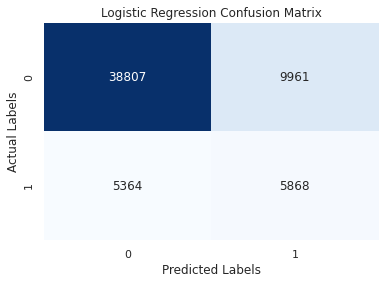

In [70]:
model_cm = confusion_matrix(val_labels, val_preds)
confusion_matrix_chart(model_cm, model_name)

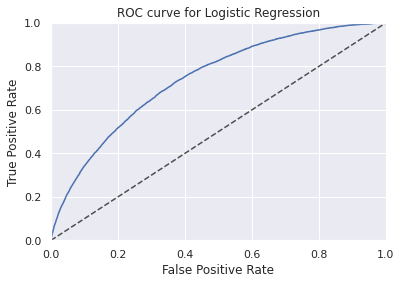

In [71]:
fpr, tpr, threshold = roc_curve(val_labels, val_pred_quant)
roc_auc_chart(fpr, tpr, model_name)

In [72]:
model_auc = auc(fpr, tpr)
print(f'Area Under the Curve (AUC): {model_auc:.2%}')

Area Under the Curve (AUC): 74.24%


In [0]:
del model

### ***Random Forest Classifier***

In [0]:
model_name = 'Random Forest Classifier'
model_file = 'RFC.pkl'
model = RandomForestClassifier(
    n_estimators=500, n_jobs=-1, verbose=1,
    class_weight={key:value for key, value in enumerate(class_weights)}
)

In [57]:
model.fit(train_data, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.6151606338205063,
                                     1: 2.6708807229183824},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [0]:
# Saving and Reloading model
joblib.dump(model, MODEL_DIR/model_file)
model = joblib.load(MODEL_DIR/model_file)

In [59]:
val_preds, val_pred_quant = model_predictions(model, val_data, val_labels)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.5s


Precision score: 77.43%
Accuracy score: 81.61%
F1 score: 51.82%
ROC AUC score: 53.26%


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.1s finished


In [60]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     48768
           1       0.56      0.08      0.14     11232

    accuracy                           0.82     60000
   macro avg       0.69      0.53      0.52     60000
weighted avg       0.77      0.82      0.76     60000



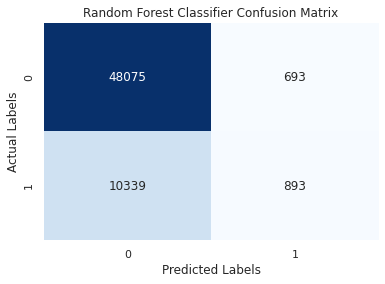

In [61]:
model_cm = confusion_matrix(val_labels, val_preds)
confusion_matrix_chart(model_cm, model_name)

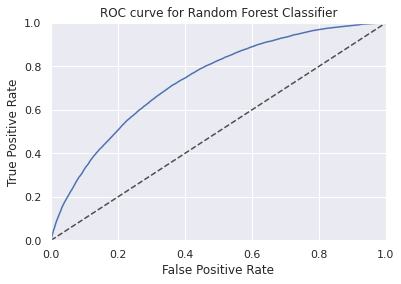

In [62]:
fpr, tpr, threshold = roc_curve(val_labels, val_pred_quant)
roc_auc_chart(fpr, tpr, model_name)

In [63]:
model_auc = auc(fpr, tpr)
print(f'Area Under the Curve (AUC): {model_auc:.2%}')

Area Under the Curve (AUC): 73.83%


In [0]:
del model